In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from prodigyopt import Prodigy

# 定义模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, categorical_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, categorical_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

class Decoder(nn.Module):
    def __init__(self, categorical_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(categorical_dim, hidden_dim_2)
        self.fc2 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc3 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # 确保输出在[0,1]范围内
        return x

def gumbel_softmax(logits, temperature):
    gs = F.gumbel_softmax(logits, tau=temperature, hard=False, dim=-1)
    return gs


In [3]:
def train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, end_lr, temperature, final_temperature, beta):
    # 加载数据
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    if dataset_name == "MNIST":
        dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "EMNIST":
        dataset = datasets.EMNIST('./data', train=True, download=True, transform=transform, split='balanced')
    dataset_img_size = dataset[0][0].shape[0]
    # get the number of classes
    classes = []
    for _, label in dataset:
        if label not in classes:
            classes.append(label)
    num_classes = len(classes)
    categorical_dim = num_classes
    input_dim = output_dim = dataset_img_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    annealing_rate = (temperature - final_temperature) / (epochs * len(dataloader))

    # 创建模型
    encoder = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim)
    decoder = Decoder(categorical_dim, hidden_dim_1, hidden_dim_2, output_dim)

    # Optimizer & Scheduler
    optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    # optimizer = Prodigy(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=(len(dataloader) * epochs), eta_min=end_lr)

    # initialize the loss lists
    recon_losses = []
    kl_losses = []
    total_losses = []
    lr_list = []
    temperature_list = []

    # initialize the progress bar
    progress_bar = tqdm(total=(len(dataloader) * epochs), desc="Training Progress")

    # train the model
    for epoch in range(epochs):
        for batch in dataloader:
            x, labels_in_batch = batch
            x = x.view(-1, input_dim)  # 确保x的形状
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            x_recon = decoder(z)

            # calculate the losses
            try:
                recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.shape[0]
            except:
                break
            log_softmax_logits = F.log_softmax(logits, dim=-1)
            uniform_distribution = torch.ones_like(log_softmax_logits) * (1.0 / categorical_dim)
            one_hot_labels = torch.zeros_like(log_softmax_logits).scatter_(1, labels_in_batch.unsqueeze(1), 1.0)
            kl_loss = F.kl_div(log_softmax_logits, one_hot_labels, reduction='sum') * beta
            loss = recon_loss + kl_loss

            # gradient descent & backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log the losses
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            total_losses.append(loss.item())
            lr_list.append(scheduler.get_last_lr()[0])
            temperature_list.append(temperature)

            # update the progress bar
            progress_bar.set_description(f'Epoch: {epoch+1}/{epochs} | Re.Loss: {recon_loss.item():.7f}, KL.Loss: {kl_loss.item():.7f} | Lr: {scheduler.get_last_lr()[0]:.7f} Temp: {temperature:.7f}', refresh=True)
            progress_bar.update(1)

            scheduler.step()  # update the learning rate
            temperature -= annealing_rate # update the temperature
            temperature = max(temperature, final_temperature)  # make sure the temperature is not lower than the minimum value

        # scheduler.step()  
        # temperature -= annealing_rate 
        # temperature = max(temperature, final_temperature)  

    progress_bar.close()
    final_loss = total_losses[-1]

    # plot the losses curve
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(kl_losses, label='KL Divergence Loss')
    plt.plot(total_losses, label='Total Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the lr curve
    plt.plot(lr_list, label='lr')
    plt.show()

    # plot the temperature curve
    plt.plot(temperature_list, label='Temperature')
    plt.show()

    return dataset, encoder, decoder, final_loss


In [4]:
import random

def visualize_images(images, num_classes, title):
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes, 1))
    for i in range(num_classes):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].axis('off')
    # plt.subplots_adjust(wspace=0.2, hspace=0.8)
    plt.suptitle(title)
    plt.show()

def sample_and_reconstruct(dataset, encoder, decoder, input_dim, num_classes, temperature):
    samples_per_class = 1
    original_images = [[] for _ in range(num_classes)]
    reconstructed_images = [[] for _ in range(num_classes)]
    selected_classes = [False] * num_classes
    
    with torch.no_grad():
        for x, y in random.sample(list(dataset), len(dataset)): # Shuffle dataset
            if all(selected_classes):
                break
            if selected_classes[y]:
                continue
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            x_recon = decoder(z)
            original_images[y].append(x.view(28, 28).numpy())
            reconstructed_images[y].append(x_recon.view(28, 28).numpy())
            selected_classes[y] = True

    visualize_images(original_images, num_classes, 'Original Images')
    visualize_images(reconstructed_images, num_classes, 'Reconstructed Images')



In [5]:
# Generate from latent vector
# categorical_dim = 10
# input_dim = 28 * 28
# temperature = 0.5

def generate_from_latent(dataset, encoder, decoder, categorical_dim, temperature):
    # init
    latent_sums = torch.zeros(categorical_dim, categorical_dim)
    class_counts = torch.zeros(categorical_dim, dtype=torch.int)

    # calculate the sum of latent vectors for each class
    with torch.no_grad():
        for img, label in dataset:
            img = img.view(-1, input_dim)
            logits = encoder(img)
            z = gumbel_softmax(logits, temperature).squeeze()
            latent_sums[label] += z
            class_counts[label] += 1

    # calculate the average latent vector for each class
    avg_latent_vector = latent_sums / class_counts[:, None]

    fig, axes = plt.subplots(1, categorical_dim, figsize=(categorical_dim, 1))

    # plot for each class
    for i in range(categorical_dim):
        generated_img = decoder(avg_latent_vector[i])
        generated_img = generated_img.view(28, 28).detach().cpu().numpy()  # 转换为numpy数组
        ax = axes[i]
        ax.imshow(generated_img, cmap='gray')
        ax.set_title(f'Class {i}')
        ax.axis('off')

    # apply transformations to EMNIST images
    if dataset_name == 'EMNIST':
        from scipy.ndimage import rotate
        plt.close(fig)  # 关闭原始图像
        rows = 5
        cols = 10
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        # fig.subplots_adjust(hspace=0.2, wspace=0.2)  # 调整子图间的间距
        fig.suptitle('Generated EMNIST Images (rotated and flipped)')

        for i in range(categorical_dim):
            row = i // cols
            col = i % cols
            generated_img = decoder(avg_latent_vector[i])
            generated_img = generated_img.view(28, 28).detach().cpu().numpy()
            generated_img = rotate(generated_img, -90)  # 逆时针旋转90度
            generated_img = np.fliplr(generated_img)  # 水平镜像
            ax = axes[row, col]
            ax.imshow(generated_img, cmap='gray')
            ax.set_title(f'Class {i}')
            ax.axis('off')
        # 隐藏多余的子图
        for i in range(categorical_dim, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        fig.tight_layout()

    plt.show()


In [6]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent(dataset_name, encoder, num_classes=10, temperature=1.0):
    # init
    latent_vectors = torch.empty(0, categorical_dim)
    Y = torch.empty(0, dtype=torch.long)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # send dataset to encoder
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            latent_vectors = torch.cat([latent_vectors, z])
            Y = torch.cat([Y, y])

    # convert latent vectors to numpy arrays
    latent_vectors = latent_vectors.cpu().numpy()
    Y = Y.cpu().numpy()

    # run t-SNE on latent vectors to get 2D embedding
    tsne = TSNE(n_components=2)
    latent_vectors_2d = tsne.fit_transform(latent_vectors)

    # plot 2D embedding
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab10')
    if dataset_name == 'EMNIST':
        scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab20')
    plt.colorbar(scatter, label='Class Labels')
    for i in range(num_classes):
        centroid = np.mean(latent_vectors_2d[Y == i], axis=0)
        plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
    plt.show()

    # cm
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # find the most likely label for each test input
    predicted_labels = latent_vectors.argmax(axis=1)

    # calculate the confusion matrix
    cm = confusion_matrix(Y, predicted_labels)

    # plot the confusion matrix
    plt.figure(figsize=(10, 8))
    if dataset_name == 'EMNIST':
        plt.figure(figsize=(50, 40))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # calculate accuracy
    from sklearn.metrics import adjusted_rand_score
    rand_index = adjusted_rand_score(Y, predicted_labels)
    print("Rand index: ", rand_index)


[I 2023-08-06 03:48:52,791] A new study created in memory with name: no-name-4408bf16-849f-4fdc-9168-322661ebb481


100%|██████████| 9912422/9912422 [00:00<00:00, 44768945.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82517502.60it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11504435.49it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21623755.70it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




Epoch: 47/47 | Re.Loss: 174.2890778, KL.Loss: 0.1984822 | Lr: 0.0000429 Temp: 0.4878099:  97%|█████████▋| 4002/4136 [12:48<00:25,  5.21it/s]   


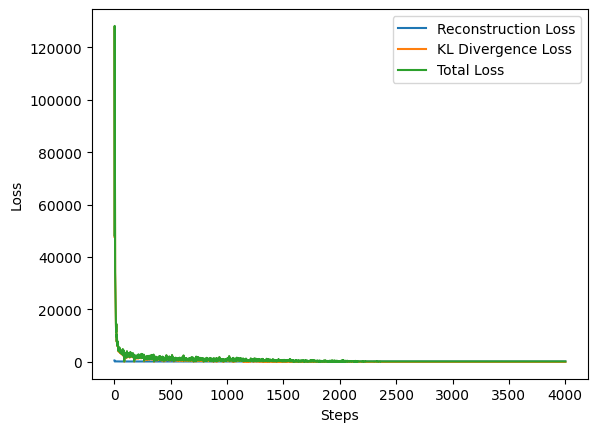

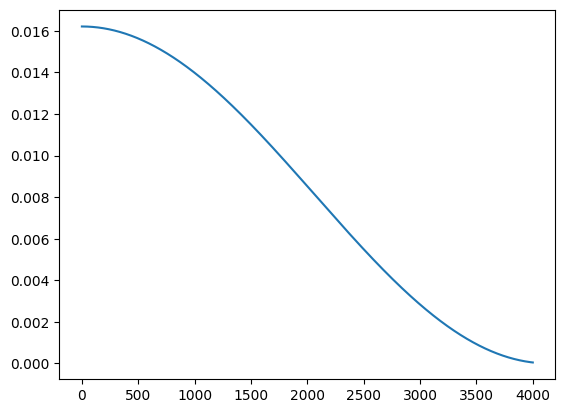

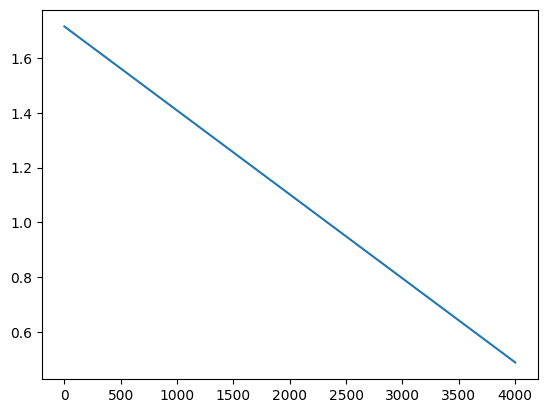

[I 2023-08-06 04:01:46,485] Trial 0 finished with value: 174.48756408691406 and parameters: {'hidden_dim_1': 761, 'hidden_dim_2': 293, 'batch_size': 689, 'epochs': 47, 'initial_lr': 0.016212746571657895, 'end_lr': 2.80515045933779e-07, 'temperature': 1.7158766544596258, 'final_temperature': 0.44637295819808, 'beta': 30.059876762486063}. Best is trial 0 with value: 174.48756408691406.


Finished trail 0/100 | Final loss: 174.48756408691406


Epoch: 390/390 | Re.Loss: 128.1965790, KL.Loss: 4.9543629 | Lr: 0.0007454 Temp: 0.7161435:  99%|█████████▉| 526743/531960 [1:30:06<00:53, 97.43it/s]  


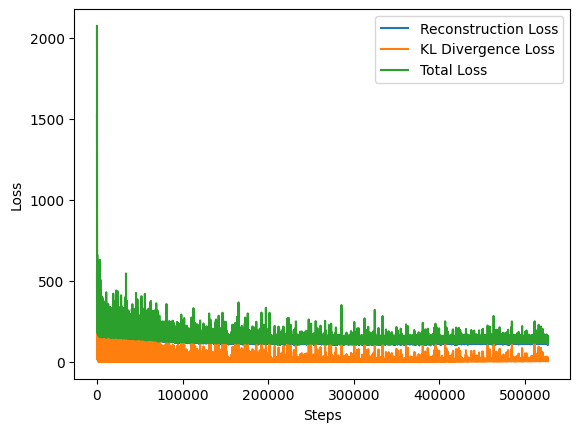

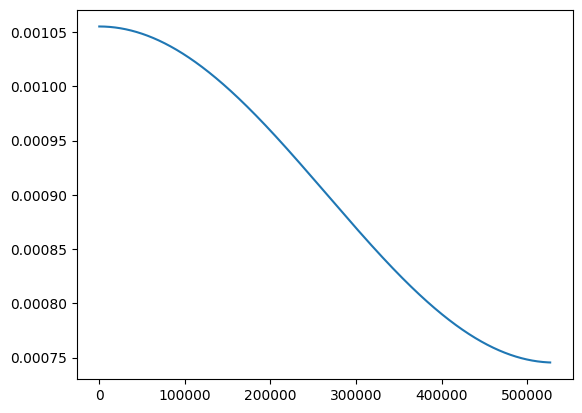

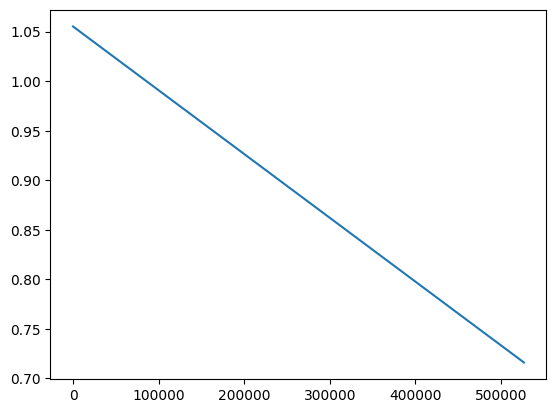

[I 2023-08-06 05:31:57,184] Trial 1 finished with value: 133.15093994140625 and parameters: {'hidden_dim_1': 194, 'hidden_dim_2': 371, 'batch_size': 44, 'epochs': 390, 'initial_lr': 0.0010552348711147944, 'end_lr': 0.0007453653694408655, 'temperature': 1.055149924340378, 'final_temperature': 0.712785207122132, 'beta': 15.107190706158196}. Best is trial 1 with value: 133.15093994140625.


Finished trail 1/100 | Final loss: 133.15093994140625


Epoch: 465/465 | Re.Loss: 172.1426392, KL.Loss: 0.0035704 | Lr: 0.0003156 Temp: 0.3125921:  99%|█████████▉| 42494/42780 [2:08:27<00:51,  5.51it/s]     


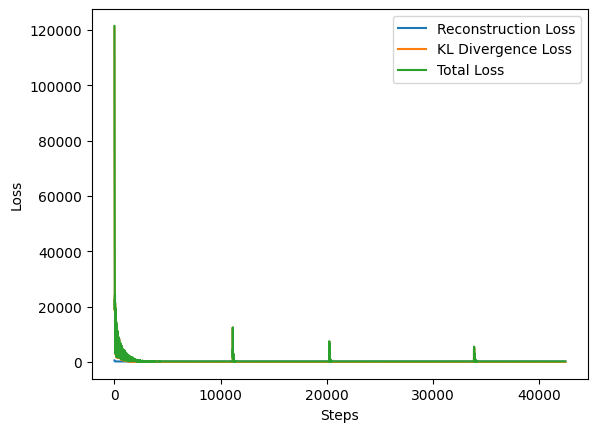

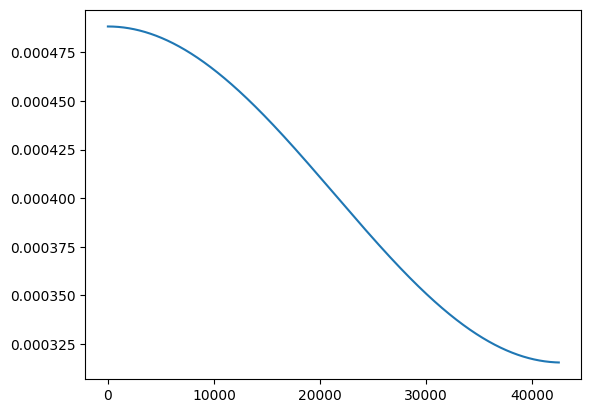

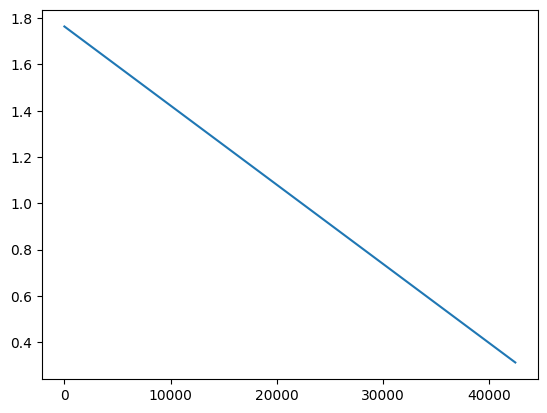

[I 2023-08-06 07:40:28,464] Trial 2 finished with value: 172.14620971679688 and parameters: {'hidden_dim_1': 810, 'hidden_dim_2': 252, 'batch_size': 658, 'epochs': 465, 'initial_lr': 0.0004882512537735148, 'end_lr': 0.00031554084028986753, 'temperature': 1.7641666498284452, 'final_temperature': 0.3027880927342726, 'beta': 79.86892821566552}. Best is trial 1 with value: 133.15093994140625.


Finished trail 2/100 | Final loss: 172.14620971679688


Epoch: 497/497 | Re.Loss: 167.2858582, KL.Loss: 35.3507957 | Lr: 0.0000040 Temp: 1.4940849: 100%|█████████▉| 52453/52682 [1:54:36<00:30,  7.63it/s]    


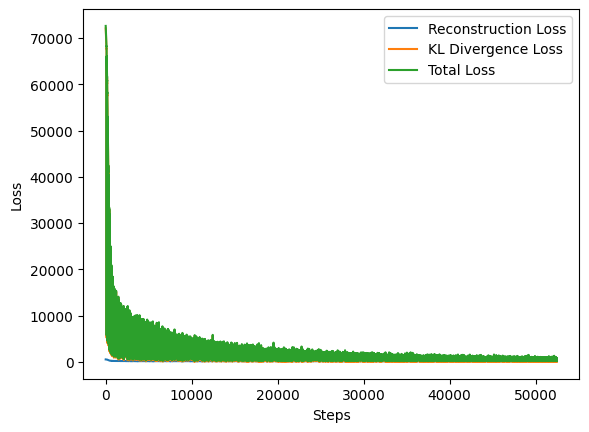

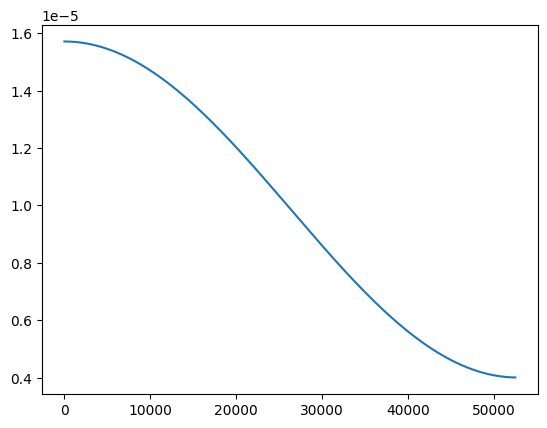

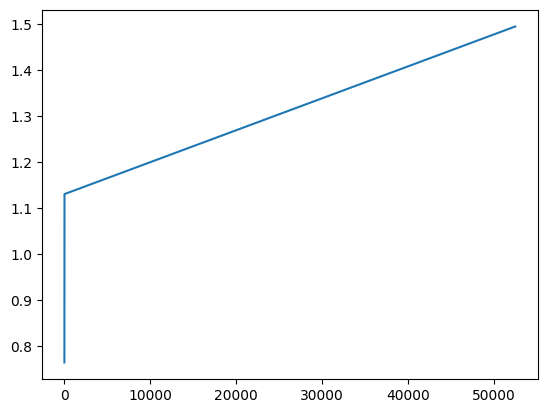

[I 2023-08-06 09:35:08,559] Trial 3 finished with value: 202.63665771484375 and parameters: {'hidden_dim_1': 579, 'hidden_dim_2': 319, 'batch_size': 571, 'epochs': 497, 'initial_lr': 1.571210616398487e-05, 'end_lr': 4.005515103633158e-06, 'temperature': 0.7637678932126584, 'final_temperature': 1.1297287235654627, 'beta': 54.82947770870793}. Best is trial 1 with value: 133.15093994140625.


Finished trail 3/100 | Final loss: 202.63665771484375


Epoch: 191/191 | Re.Loss: 175.0446014, KL.Loss: 0.2168392 | Lr: 0.0005145 Temp: 0.9968581:  99%|█████████▉| 17672/17763 [1:09:24<00:21,  4.24it/s]  


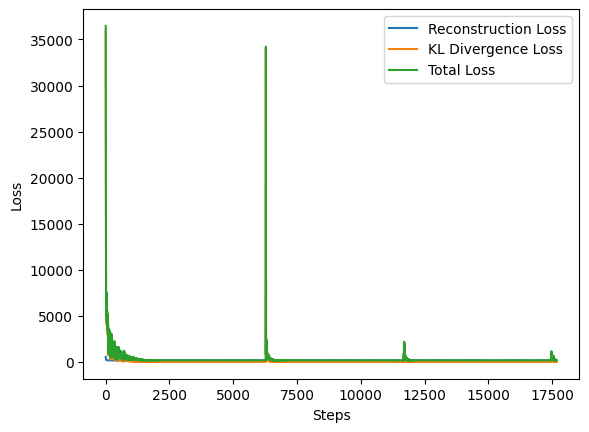

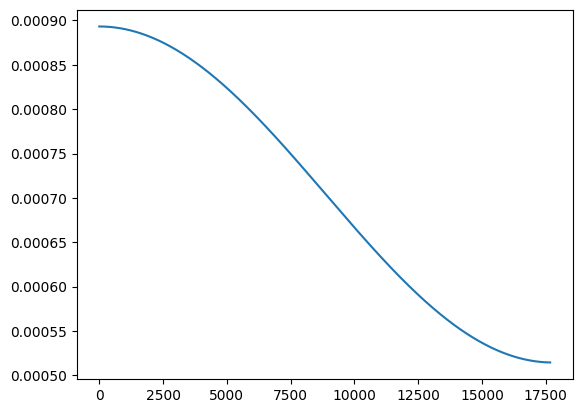

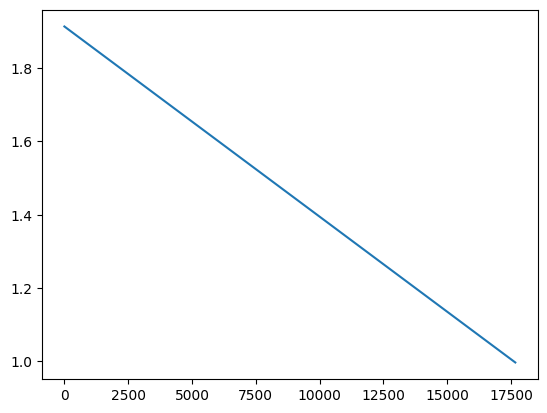

[I 2023-08-06 10:44:36,573] Trial 4 finished with value: 175.26144409179688 and parameters: {'hidden_dim_1': 949, 'hidden_dim_2': 438, 'batch_size': 651, 'epochs': 191, 'initial_lr': 0.0008932048886874423, 'end_lr': 0.0005144645937036856, 'temperature': 1.9135909991699052, 'final_temperature': 0.992085346690187, 'beta': 23.956915834764153}. Best is trial 1 with value: 133.15093994140625.


Finished trail 4/100 | Final loss: 175.26144409179688


Epoch: 502/502 | Re.Loss: 273.4476013, KL.Loss: 0.0000000 | Lr: 0.0001075 Temp: 1.0062707:  99%|█████████▉| 65716/66264 [1:35:08<00:47, 11.51it/s]   


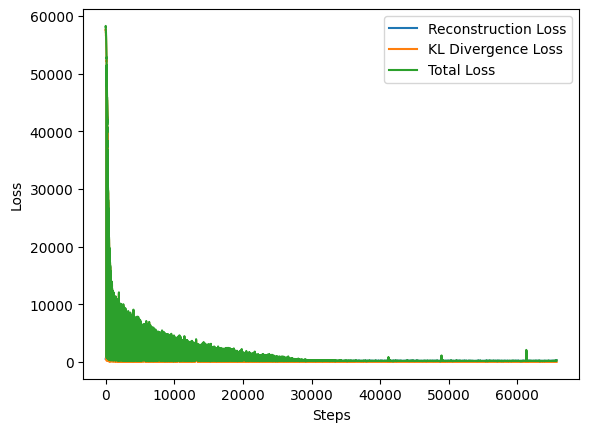

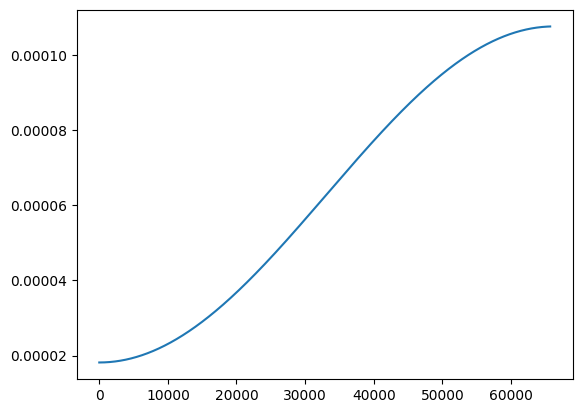

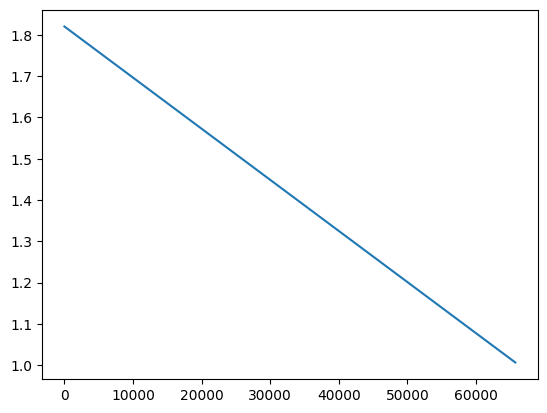

[I 2023-08-06 12:19:48,785] Trial 5 finished with value: 273.4476013183594 and parameters: {'hidden_dim_1': 390, 'hidden_dim_2': 401, 'batch_size': 458, 'epochs': 502, 'initial_lr': 1.8173780648957153e-05, 'end_lr': 0.00010751760442479131, 'temperature': 1.8202738116551007, 'final_temperature': 0.9994702753631698, 'beta': 54.61919874780707}. Best is trial 1 with value: 133.15093994140625.


Finished trail 5/100 | Final loss: 273.4476013183594


Epoch: 507/507 | Re.Loss: 164.0566101, KL.Loss: 3.7862787 | Lr: 0.0000007 Temp: 0.7156237:  99%|█████████▉| 41581/42081 [2:22:33<01:42,  4.86it/s]      


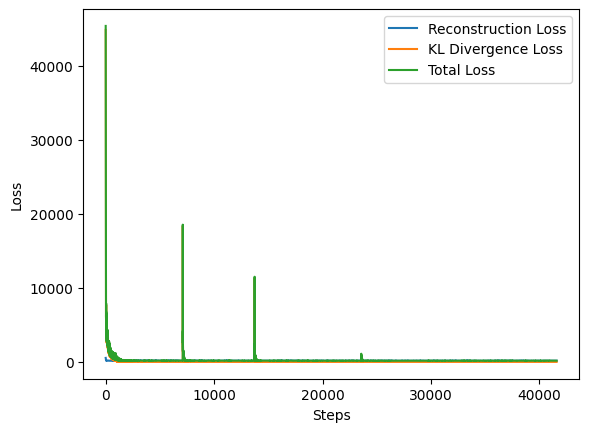

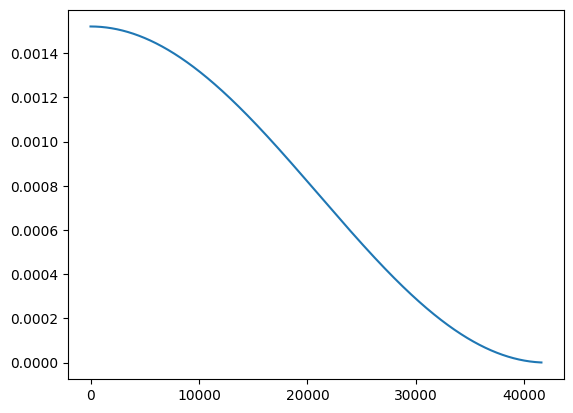

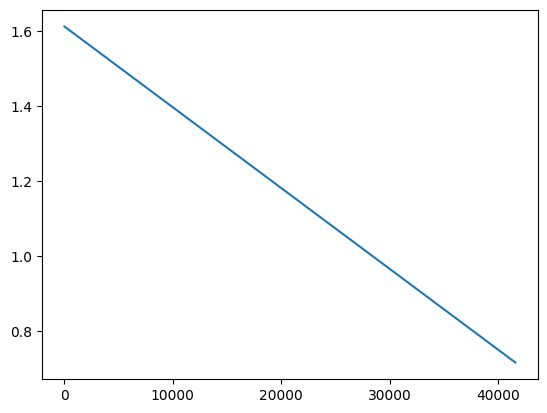

[I 2023-08-06 14:42:25,223] Trial 6 finished with value: 167.8428955078125 and parameters: {'hidden_dim_1': 704, 'hidden_dim_2': 81, 'batch_size': 726, 'epochs': 507, 'initial_lr': 0.0015205771156809242, 'end_lr': 1.2906349975933222e-07, 'temperature': 1.6129159080200823, 'final_temperature': 0.7048121346512806, 'beta': 26.796836780287038}. Best is trial 1 with value: 133.15093994140625.


Finished trail 6/100 | Final loss: 167.8428955078125


Epoch: 233/233 | Re.Loss: 169.4958954, KL.Loss: 11477.2656250 | Lr: 0.0000413 Temp: 0.7597891:  99%|█████████▊| 25261/25630 [1:05:44<00:57,  6.40it/s]    


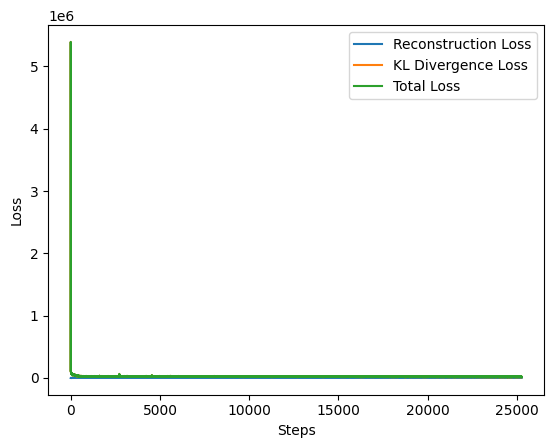

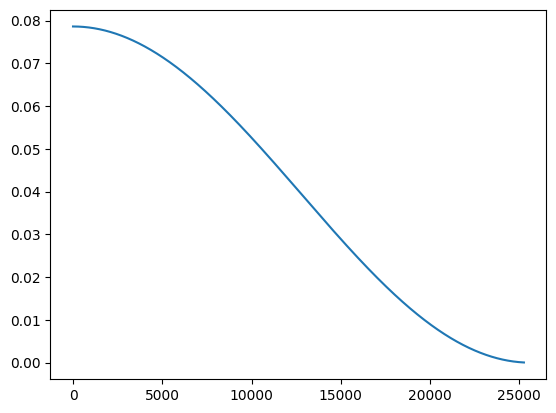

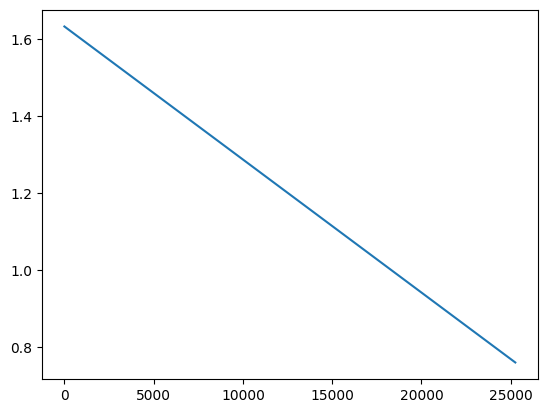

[I 2023-08-06 15:48:13,020] Trial 7 finished with value: 11646.76171875 and parameters: {'hidden_dim_1': 227, 'hidden_dim_2': 261, 'batch_size': 547, 'epochs': 233, 'initial_lr': 0.07863237623944745, 'end_lr': 8.986371524518552e-07, 'temperature': 1.632675150812798, 'final_temperature': 0.7470033598035589, 'beta': 90.88412807890084}. Best is trial 1 with value: 133.15093994140625.


Finished trail 7/100 | Final loss: 11646.76171875


Epoch: 456/456 | Re.Loss: 127.2130280, KL.Loss: 1.9955890 | Lr: 0.0000015 Temp: 1.0512962: 100%|█████████▉| 635293/636576 [5:15:26<00:38, 33.57it/s]      


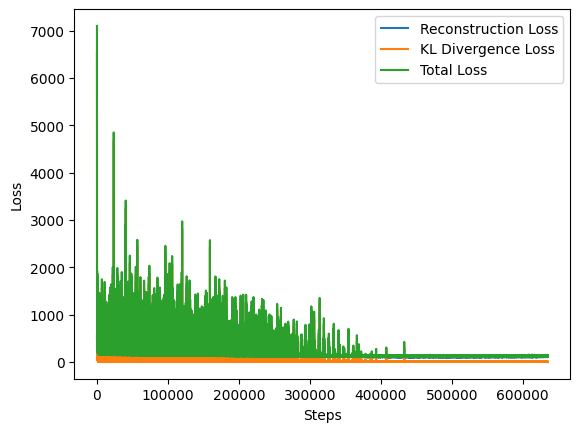

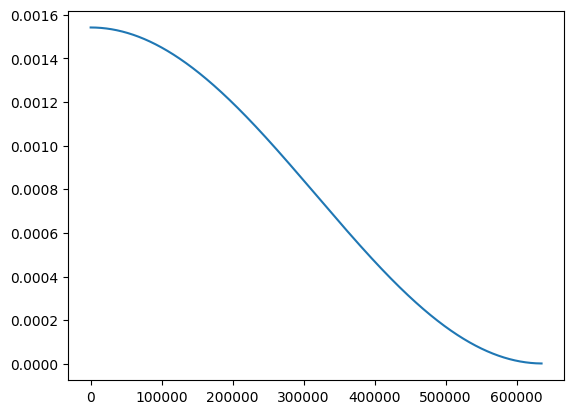

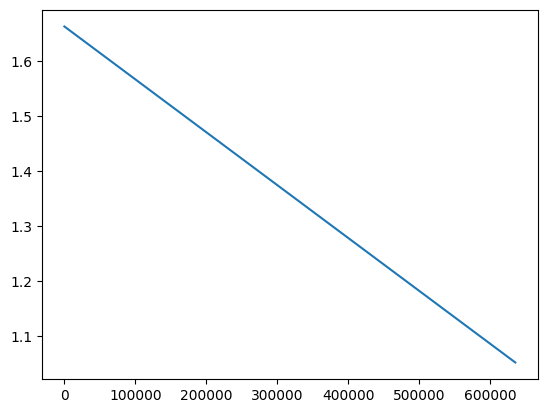

[I 2023-08-06 21:20:11,132] Trial 8 finished with value: 129.2086181640625 and parameters: {'hidden_dim_1': 363, 'hidden_dim_2': 480, 'batch_size': 43, 'epochs': 456, 'initial_lr': 0.0015420514092692919, 'end_lr': 1.4955831466603032e-06, 'temperature': 1.6633594186620007, 'final_temperature': 1.0500591031151123, 'beta': 66.28751282106015}. Best is trial 8 with value: 129.2086181640625.


Finished trail 8/100 | Final loss: 129.2086181640625


Epoch: 307/307 | Re.Loss: 174.1297302, KL.Loss: 0.2532493 | Lr: 0.0000093 Temp: 1.0302212:  99%|█████████▉| 18600/18727 [34:39<00:14,  8.95it/s] 


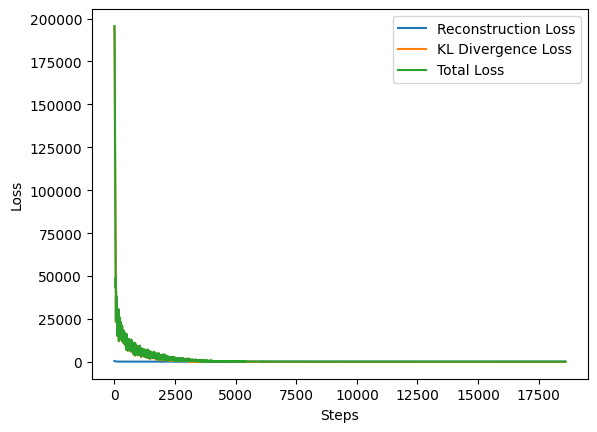

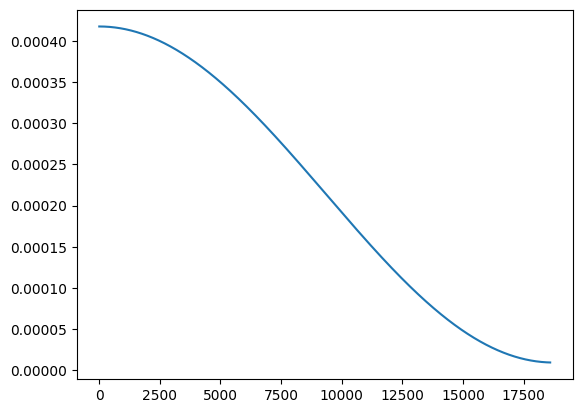

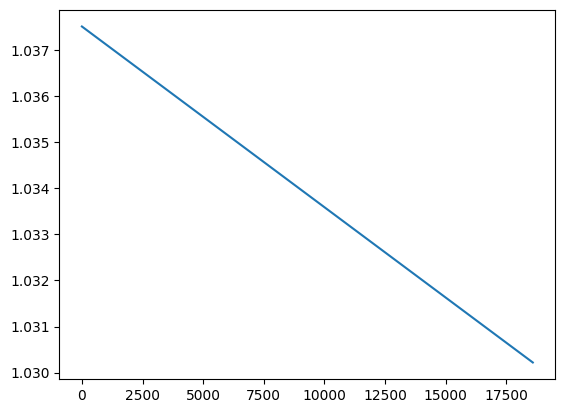

[I 2023-08-06 21:54:53,550] Trial 9 finished with value: 174.3829803466797 and parameters: {'hidden_dim_1': 192, 'hidden_dim_2': 228, 'batch_size': 990, 'epochs': 307, 'initial_lr': 0.00041780085246732965, 'end_lr': 9.258464091693593e-06, 'temperature': 1.0375085661097692, 'final_temperature': 1.0301710098343273, 'beta': 85.45783354279135}. Best is trial 8 with value: 129.2086181640625.


Finished trail 9/100 | Final loss: 174.3829803466797


Epoch: 360/360 | Re.Loss: 104.7812881, KL.Loss: 0.4865052 | Lr: 0.0000555 Temp: 1.5163291:  99%|█████████▉| 382428/385920 [1:52:16<01:01, 56.77it/s]  


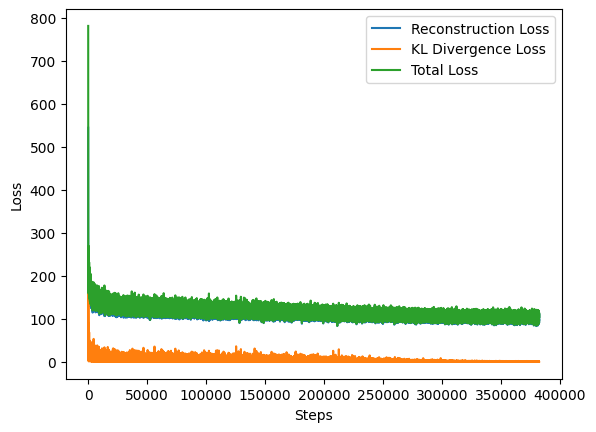

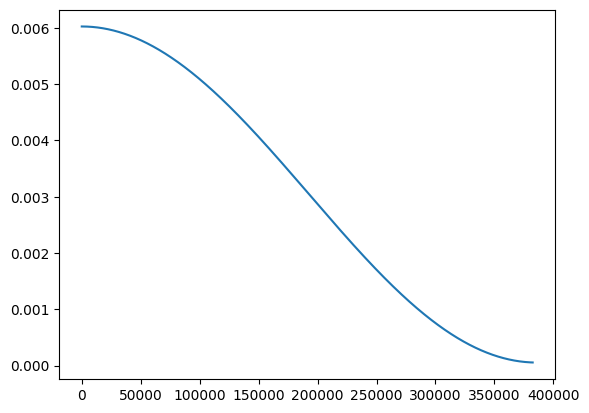

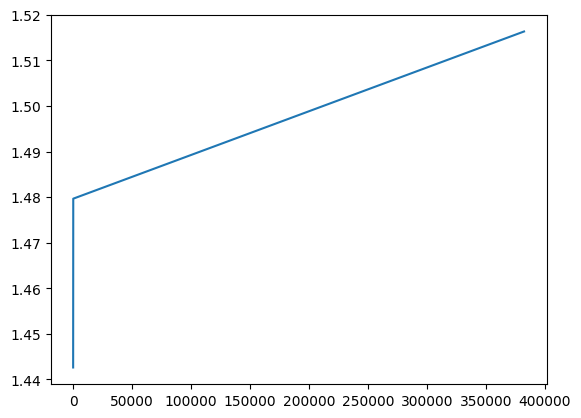

[I 2023-08-06 23:47:14,243] Trial 10 finished with value: 105.26779174804688 and parameters: {'hidden_dim_1': 425, 'hidden_dim_2': 500, 'batch_size': 56, 'epochs': 360, 'initial_lr': 0.006023831168192716, 'end_lr': 5.4270549432123517e-05, 'temperature': 1.4426243165789046, 'final_temperature': 1.479644293752712, 'beta': 1.8306740838455156}. Best is trial 10 with value: 105.26779174804688.


Finished trail 10/100 | Final loss: 105.26779174804688


Epoch: 364/364 | Re.Loss: 109.2447662, KL.Loss: 0.7000473 | Lr: 0.0000332 Temp: 1.5095895:  99%|█████████▉| 373509/376740 [1:54:49<00:59, 54.22it/s]   


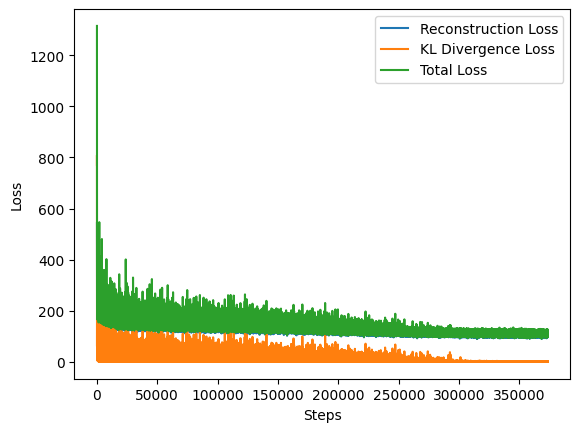

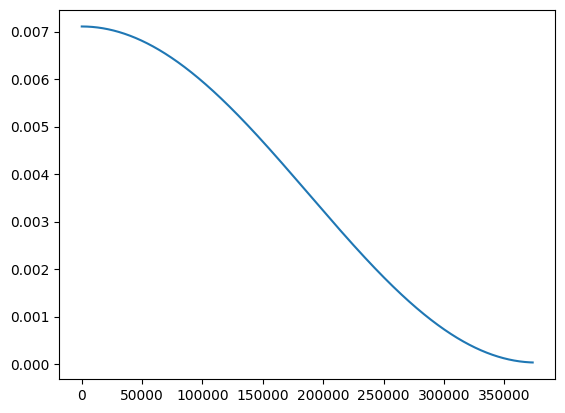

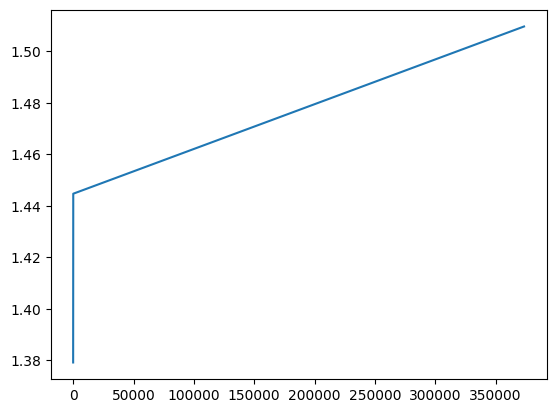

[I 2023-08-07 01:42:07,435] Trial 11 finished with value: 109.94481658935547 and parameters: {'hidden_dim_1': 426, 'hidden_dim_2': 512, 'batch_size': 58, 'epochs': 364, 'initial_lr': 0.0071072133572833915, 'end_lr': 3.191464909176211e-05, 'temperature': 1.3792000360180463, 'final_temperature': 1.4446757309751133, 'beta': 5.777463102548344}. Best is trial 10 with value: 105.26779174804688.


Finished trail 11/100 | Final loss: 109.94481658935547


Epoch: 19/363 | Re.Loss: 154.5935974, KL.Loss: 3.4281840 | Lr: 0.0078554 Temp: 1.4916058:   5%|▌         | 4454/86757 [04:33<1:27:45, 15.63it/s]  

In [7]:
# 超参数调优
import optuna

current_trial = 0

# 记录文件名
log_file = 'trials_log.txt'

def objective(trial):
    torch.cuda.empty_cache()
    global current_trial
    dataset_name = 'MNIST'
    hidden_dim_1 = trial.suggest_int('hidden_dim_1', 128, 1024)
    hidden_dim_2 = trial.suggest_int('hidden_dim_2', 32, 512)
    batch_size = trial.suggest_int('batch_size', 16, 1024)
    epochs = trial.suggest_int('epochs', 32, 512)
    initial_lr = trial.suggest_float('initial_lr', 1e-5, 1e-1, log=True)
    end_lr = trial.suggest_float('end_lr', 1e-7, 1e-3, log=True)
    temperature = trial.suggest_float('temperature', 0.5, 2.0)
    final_temperature = trial.suggest_float('final_temperature', 0.1, 1.5)
    beta = trial.suggest_float('beta', 0.01, 100.0)
    
    dataset, encoder, decoder, final_loss = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, end_lr, temperature, final_temperature, beta)
    
    print(f'Finished trail {current_trial}/100 | Final loss: {final_loss}')
    current_trial += 1
    
    # 记录参数和结果
    with open(log_file, 'a') as f:
        f.write(f'Trial {current_trial}: \n')
        f.write(f'    Hidden Dim 1: {hidden_dim_1}\n')
        f.write(f'    Hidden Dim 2: {hidden_dim_2}\n')
        f.write(f'    Batch Size: {batch_size}\n')
        f.write(f'    Epochs: {epochs}\n')
        f.write(f'    Initial LR: {initial_lr}\n')
        f.write(f'    Temperature: {temperature}\n')
        f.write(f'    Final Temperature: {final_temperature}\n')
        f.write(f'    Beta: {beta}\n')
        f.write(f'    Final Loss: {final_loss}\n')
        f.write('-' * 50 + '\n')
    
    return final_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


In [ ]:
dataset_name = 'MNIST'
hidden_dim_1 = 512
hidden_dim_2 = 256
batch_size = 32
epochs = 4
initial_lr = 1e-3
temperature = 1.0
final_temperature = 0.3

dataset, encoder, decoder, final_loss = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature)

In [ ]:
sample_and_reconstruct(dataset, encoder, decoder, input_dim=28*28, num_classes=10, temperature=0.5)

In [ ]:
categorical_dim = 10
input_dim = 28 * 28
temperature = 0.5
generate_from_latent(dataset, encoder, decoder, categorical_dim=10, temperature=0.5)

In [ ]:
visualize_latent(dataset_name, encoder, num_classes=10, temperature=0.5)